# Quantum Computer lab 5

These lab exercises are **NOT** part of the assesment of the module, but they should be useful training for the coursework.

* Please run the code to make sure it works



## Background to the variational quantum eigensolver

*  https://en.wikipedia.org/wiki/Variational_quantum_eigensolver
*  https://en.wikipedia.org/wiki/Rayleigh%E2%80%93Ritz_method

The VQE computes the eigenvalues of an operator. The optimization is run on the classical computer


##  Installing pennylane on the University machines and your laptop

There are instructions on how to install pennylane on your computer at: https://pennylane.ai/install/

In the annaconda prompt or terminal on a Mac type 

pip install pennylane --upgrade

If you have spyder running you may need to restart spyder to access the library.

You will have to run this command everytime you work on a new PC in the lab.

There may be  additional complications with the University PCs,because of administrative rights. 

### Additional packages to be installed

I had to install the packages below to get this python script to run

conda install conda-forge::h5py

conda install conda-forge::fsspec

conda install conda-forge::aiohttp

pip install optax

pip install  jax



## Exercises on the Variational Quantum Eigensolver

Based on https://pennylane.ai/qml/demos/tutorial_vqe

The example computes the energy of the $H_2$ molecule.

The parameters of the molecule are loaded using the qml.data.load method


In [24]:
import pennylane as qml

dataset = qml.data.load('qchem', molname="H2")[0]
H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is  -0.09963387941370971 * I(0) + 0.17110545123720233 * Z(0) + 0.17110545123720225 * Z(1) + 0.16859349595532533 * (Z(0) @ Z(1)) + 0.04533062254573469 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04533062254573469 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04533062254573469 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04533062254573469 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.22250914236600539 * Z(2) + 0.12051027989546245 * (Z(0) @ Z(2)) + -0.22250914236600539 * Z(3) + 0.16584090244119712 * (Z(0) @ Z(3)) + 0.16584090244119712 * (Z(1) @ Z(2)) + 0.12051027989546245 * (Z(1) @ Z(3)) + 0.1743207725924201 * (Z(2) @ Z(3))


In [25]:
print(dataset)

<Dataset = molname: H2, basis: STO-3G, bondlength: 0.742, attributes: ['molname', 'basis', ...]>


The quantum simulator 

In [26]:
dev = qml.device("lightning.qubit", wires=qubits)

Define the quantum circuit that prepares the trial
state of the molecule. We want to prepare states of the form,

$$\vert \Psi(\theta) \rangle = \cos(\theta/2)~|1100\rangle -\sin(\theta/2)~|0011\rangle,$$

where $\theta$ is the variational parameter to be optimized in order to
find the best approximation to the true ground state. In the
Jordan-Wigner encoding, the first term $|1100\rangle$ represents the
[Hartree-Fock (HF)
state](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method) where
the two electrons in the molecule occupy the lowest-energy orbitals. The
second term $|0011\rangle$ encodes a double excitation of the HF state
where the two particles are excited from qubits 0, 1 to 2, 3.

The quantum circuit to prepare the trial state
$\vert \Psi(\theta) \rangle$ is schematically illustrated in the figure
below.

![vqe](https://github.com/cmcneile/Quantum_Computing_lab_2024/blob/main/vqecircuit.png?raw=true)

In this figure, the gate $G^{(2)}$ corresponds to the
`~.pennylane.DoubleExcitation`{.interpreted-text role="class"}
operation, implemented in PennyLane as a [Givens
rotation](https://en.wikipedia.org/wiki/Givens_rotation), which couples
the four-qubit states $\vert 1100 \rangle$ and $\vert 0011 \rangle.$ For
more details on how to use the excitation operations to build quantum
circuits for quantum chemistry applications see the tutorial
`tutorial_givens_rotations`

Implementing the circuit above using PennyLane is straightforward.
First, we use the `hf_state` function to
generate the vector representing the Hartree-Fock state.


In [27]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [28]:
@qml.qnode(dev, interface="jax")
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

We can now define our error function simply as the expected value calculated above:

This is function that is minimized


In [29]:
def cost_fn(param):
    return circuit(param, wires=range(qubits))


Now we proceed to minimize the cost function to find the ground state of the  $H_2$
  molecule. To start, we need to define the classical optimizer. The library optax (https://optax.readthedocs.io/en/latest/) offers different optimizers. Here we use a basic gradient-descent optimizer. We carry out the optimization over a maximum of 100 steps aiming to reach a convergence tolerance of  
$10^{-6}$ for the value of the cost function


In [30]:
import optax

max_iterations = 100
conv_tol = 1e-06

opt = optax.sgd(learning_rate=0.4)

In [31]:
from jax import numpy as np
import jax

The angle $\theta$ is optimized to minimze the energy.

The energy is units of Hartee  https://en.wikipedia.org/wiki/Hartree

In [32]:


#import numpy as np
theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)

    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -1.12772107 Ha
Step = 1,  Energy = -1.13287044 Ha
Step = 2,  Energy = -1.13524628 Ha
Step = 3,  Energy = -1.13633823 Ha
Step = 4,  Energy = -1.13683927 Ha
Step = 5,  Energy = -1.13706899 Ha
Step = 6,  Energy = -1.13717425 Ha
Step = 7,  Energy = -1.13722253 Ha
Step = 8,  Energy = -1.13724458 Ha
Step = 9,  Energy = -1.13725471 Ha
Step = 10,  Energy = -1.13725936 Ha
Step = 11,  Energy = -1.13726151 Ha
Step = 12,  Energy = -1.13726246 Ha

Final value of the ground-state energy = -1.13726246 Ha

Optimal value of the circuit parameter = 0.2250


1 Ha is 27.2 eV

So the energy of $H_2$ state id 27.3 * (-1.13726246 ) = -31 eV


Plot the values of the ground state energy of the molecule and the gate parameter $\theta$ as a function of the optimization step.

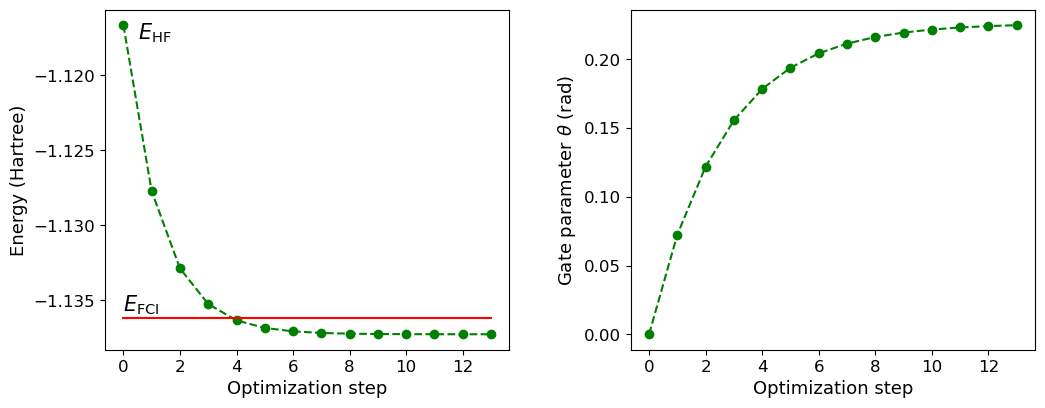

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

## Theory papers about H2 molecule

*  Theory paper on the $H_2$ molecule http://users.df.uba.ar/ferraro/e3/teoricas-2020/KOLOS-WOLONIEWICZ/kolos1968.pdf